In [3]:
# Tensorflow와 Keras는 함께 발전하고 있는 상태임.
# Tensorflow를 사용하되, Keras를 이용해서 하고 있는 상태임.
# CNN
# 예를 들어, 영화는 시간순서, 순서가 중요하게 되는데
# 이미지는 공간적 배치 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from matplotlib.image import imread

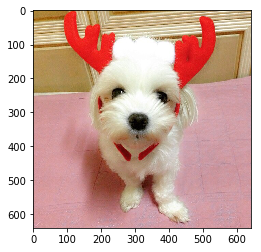

In [6]:
mozzi = imread('data/mozzi.jpg')

plt.imshow(mozzi)

합성곱 연산을 활용한 수직 방향 모서리 탐지

In [7]:
kernel = np.array([-1, 1])
kernel

array([-1,  1])

In [8]:
kernel = kernel.reshape(1, 2, 1)
kernel

array([[[-1],
        [ 1]]])

In [9]:
# 실질적으로는 convolution을 수행하는 것임.
from scipy.signal import correlate

In [10]:
edges = correlate(mozzi, kernel, mode='same')
edges.shape

/Users/1000165/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


(640, 640, 3)

In [11]:
edges[:, :, 0]

array([[162,   7,   5, ...,  -6,  -5,  -2],
       [166,   3,   3, ...,  -3,  -3,   0],
       [169,   0,  -1, ...,  -3,  -2,   0],
       ...,
       [207, -11,  13, ...,  -1,   1,   3],
       [193,   8,   0, ...,  -7,  -6,  -1],
       [203,   1,   4, ...,   0,   5,   7]])

In [12]:
mozzi[:, :, 0]
## 우리의 목표는 오른쪽 - 왼쪽: 169 - 162 = 7

array([[162, 169, 174, ..., 201, 196, 194],
       [166, 169, 172, ..., 196, 193, 193],
       [169, 169, 168, ..., 186, 184, 184],
       ...,
       [207, 196, 209, ..., 211, 212, 215],
       [193, 201, 201, ..., 213, 207, 206],
       [203, 204, 208, ..., 207, 212, 219]], dtype=uint8)

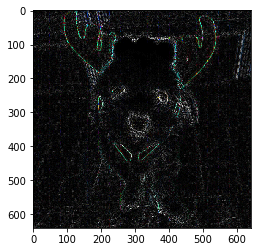

In [13]:
result_image = np.abs(edges)
result_image = result_image.astype('uint8')
plt.imshow(result_image * 4)
# '오른쪽 - 왼쪽' 한 결과만으로도 어떤 의미있는 결과가 나옴. 윤곽이 어느정도 구분이 됨.

In [14]:
from deepy.dataset import cifar10

In [15]:
(X_train, y_train), (X_test, y_test) = cifar10.load('data/cifar-10-batches-py/')

In [16]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000,))

In [17]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [18]:
Y_train = pd.get_dummies(y_train).values
Y_test = pd.get_dummies(y_test).values

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Flatten, MaxPooling2D

Using TensorFlow backend.


### DropOut을 활용한 과적합 개선 시도

In [49]:
from keras.layers import Dropout

In [51]:
model = Sequential()
# 1층
model.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 출력 준비
model.add(Flatten())
model.add(Dense(512, activation='relu'))

# 출력층
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 4,200,842
Trainable params: 4,200,842
Non-trainable params: 0
_________________________________________________________________


In [22]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 아래 에러때문에 추가함.
# 2018-11-30 10:33:28.913283: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
# 2018-11-30 10:33:28.914887: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
# OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
# OMP: Hint: This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://www.intel.com/software/products/support/.

In [23]:
histroy = model.fit(X_train, Y_train, batch_size=100, epochs=20, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 40s 993us/step - loss: 1.5194 - acc: 0.4616 - val_loss: 1.2969 - val_acc: 0.5477
Epoch 2/20
40000/40000 [==============================] - 42s 1ms/step - loss: 1.1799 - acc: 0.5858 - val_loss: 1.1433 - val_acc: 0.6030
Epoch 3/20
40000/40000 [==============================] - 44s 1ms/step - loss: 1.0422 - acc: 0.6347 - val_loss: 1.0908 - val_acc: 0.6218
Epoch 4/20
40000/40000 [==============================] - 42s 1ms/step - loss: 0.9433 - acc: 0.6677 - val_loss: 1.0446 - val_acc: 0.6381
Epoch 5/20
40000/40000 [==============================] - 41s 1ms/step - loss: 0.8568 - acc: 0.6983 - val_loss: 1.0392 - val_acc: 0.6428
Epoch 6/20
40000/40000 [==============================] - 41s 1ms/step - loss: 0.7695 - acc: 0.7318 - val_loss: 1.0011 - val_acc: 0.6552
Epoch 7/20
40000/40000 [==============================] - 41s 1ms/step - loss: 0.6864 - acc: 0.7615 - val_loss: 1.0393 - val_a

In [24]:
# max pooling을 상당히 조심스럽게 대응해야 할 수도 있음.

In [25]:
# 학습을 통해서 kernel = filter에 의미있는 값들이 알아서 설정되기를 바라고 있음.

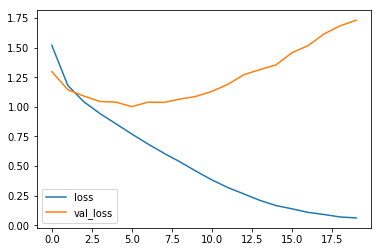

In [31]:
histroy
train_result = pd.DataFrame(histroy.history)

train_result[['loss', 'val_loss']].plot()

In [32]:
Y_pred = model.predict(X_test)

In [42]:
pd.DataFrame(Y_pred)[-5:]

,0,1,2,3,4,5,6,7,8,9
9995,2.356674e-03,4.394252e-10,3.550136e-09,9.490714e-01,3.456227e-06,4.488998e-02,2.714535e-11,6.640647e-07,3.677751e-03,1.268218e-08
9996,4.900691e-12,2.895636e-17,1.098860e-05,2.392601e-04,1.402250e-05,9.996568e-01,7.877999e-05,5.960942e-08,1.688143e-13,1.168318e-11
9997,1.114973e-08,1.119708e-09,1.848217e-02,1.779548e-05,1.768485e-07,9.812338e-01,5.380027e-06,7.071529e-06,2.534213e-04,7.781530e-08
9998,2.166681e-01,7.831246e-01,6.045850e-06,3.639722e-05,1.256963e-04,4.599966e-06,4.782068e-10,3.327487e-06,5.689259e-08,3.107903e-05
9999,2.201826e-12,1.116279e-10,2.665098e-09,6.583292e-11,7.440232e-05,2.137848e-08,7.881108e-11,9.999256e-01,1.102797e-14,6.722572e-13


In [43]:
Y_pred = model.predict(X_test)

In [44]:
y_pred = np.argmax(Y_pred, axis=1)

In [45]:
np.mean(y_pred == y_test)

0.6397

In [ ]:
# 훈련점수는 좋은데, 테스트 점수는 안 좋은 상황. 과대적합(overfit)이 발생함.
# 성능도 좋으면서 Train ~ Test의 간격이 좁아지는 모양을 바람.
# 모델이 문제인지 샘플이 문제인지 확인을 해야 함.
# 과대적합이 발생한 경우는 어떻게 문제를 해결해 나가야 하나
# 일단 훈련점수(성능)은 좋은 상태임.
# 점수를 너무 많이 올리면 문제가 될 수 있다. 무슨 문제가 발생하냐면 새로운 모양이 들어 왔을때,
# 점수도 어느 정도 좋으면서 새로운 데이터에 대한 적응능력도 존재 해야 함.


In [ ]:
# 한 70%의 샘플의 갯수로 테스트했을 때 샘플의 수를 더 늘려도 성능이 더 나아지지 않는 결과를 보일 때
# 이거는 모델을 바꿔야지 개선ㅇ르 할 수 있다는 의미가 될 수 있다. 샘플의 갯수는 결국 비용문제가 발생할 수 있는 것임.

In [47]:
# 가중치이ㅡ 값이 커질 수록 표현력이 커지는 경향이 있음. 적당한 가중치를 찾는 것이 중요함. 벌칙과 가중치는 반비례함.
# but 신경망에서는 잘 사용하지 않는 기법임.
# 그러면 신경망에서는 어떤 기법을 사용하는가? 드롭아웃을 사용함.
# 노드의 갯수는 손가락과 같음. 데이터가 복잡하면 노드의 갯수, 손가락이 더 많은 게 편함.

In [ ]:
# 과적합은 훈련데이터에는 성능이 좋으나, 새로운 데이터에 대해서는 적응력이 좋지 않다는 것임.
# 
# 일단 잠재력이 있어야 함. 그 중에서 도움이 안되는 특성들이 있을 수 있음. 이런 건 지워서 복잡도를 줄이겠다는 게 신경망에서 하려는 것임.

In [52]:
model = Sequential()
# 1층
model.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25)) # 25%를 줄이는 것임. 표현력이 너무 과도해서 표현력을 좀 줄이려고 함.

# 출력 준비
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # 50%를 줄이는 것임. 표현력이 너무 과도해서 표현력을 좀 줄이려고 함.

# 출력층
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [53]:
histroy = model.fit(X_train, Y_train, batch_size=100, epochs=20, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 58s 1ms/step - loss: 1.6473 - acc: 0.4085 - val_loss: 1.3421 - val_acc: 0.5260
Epoch 2/20
40000/40000 [==============================] - 57s 1ms/step - loss: 1.3331 - acc: 0.5236 - val_loss: 1.2227 - val_acc: 0.5664
Epoch 3/20
40000/40000 [==============================] - 54s 1ms/step - loss: 1.2160 - acc: 0.5678 - val_loss: 1.1448 - val_acc: 0.5957
Epoch 4/20
40000/40000 [==============================] - 55s 1ms/step - loss: 1.1390 - acc: 0.5982 - val_loss: 1.0642 - val_acc: 0.6284
Epoch 5/20
40000/40000 [==============================] - 54s 1ms/step - loss: 1.0728 - acc: 0.6205 - val_loss: 1.0617 - val_acc: 0.6271
Epoch 6/20
40000/40000 [==============================] - 53s 1ms/step - loss: 1.0210 - acc: 0.6368 - val_loss: 1.0159 - val_acc: 0.6482
Epoch 7/20
40000/40000 [==============================] - 52s 1ms/step - loss: 0.9759 - acc: 0.6569 - val_loss: 1.0028 - val_acc

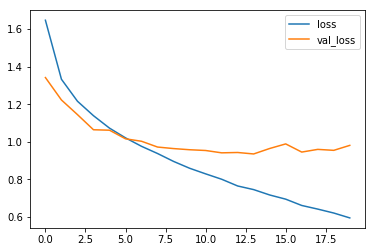

In [56]:
histroy
train_result = pd.DataFrame(histroy.history)

train_result[['loss', 'val_loss']].plot()

In [55]:
# 특징은 다 뽑아놓고 의미 없는 특징을 줄여준다는 것 vs 아예 특징 자체를 줄여 놓는 것은 의미가 다름.
# 다만 우리가 어떤 특징이 의미가 있는 것인지는 기계가 학습하면서 알아서 해주기를 바람.
# 이를 위해서 무작위로 기계가 학습하면서 꺼서 의미 있는 것을 발라내려고 함.

In [57]:
# train ~ test 간의 간격은 줄었는데, 성능 자체가 너무 떨어짐.
# 이는 모델이 문제인 것 같음.
# 층수가 너무 부족해서 일 수 있지 않을까 생각해볼 수 있음.

In [58]:
# 알파고가 만능이라면 어떤 데이터를 넣어도 되고, 알파고만 사용하면 되지만,
# 알바고는 바둑의 문제에 특화되어 있음.

In [59]:
# 내 데이터에 맞추어서 결정트리를 바꿀 수는 없음. 결정트리는 그대로 사용하고, 몇 가지 설정만 바꿔야 하는 것임.

In [60]:
# google에서 cifar 10 results 검색.
# 99% 달성은 아직 못 하고 있음.

### STRIVING FOR SIMPLICITY: THE ALL CONVOLUTIONAL NET
- https://arxiv.org/pdf/1412.6806.pdf

In [67]:
from keras.layers import GlobalAveragePooling2D

In [69]:
model = Sequential()

model.add(Conv2D(96, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(Conv2D(96, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(96, kernel_size=(3,3), padding='same', strides=(2,2), activation='relu'))

model.add(Conv2D(192, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(Conv2D(192, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(192, kernel_size=(3,3), padding='same', strides=(2,2), activation='relu'))

model.add(Conv2D(192, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(192, kernel_size=(1,1), padding='same', activation='relu'))
model.add(Conv2D(10, kernel_size=(1,1), padding='same', activation='relu'))

model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

In [71]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 96)        83040     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 192)       331968    
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 8, 8, 192)         331968    
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 8, 8, 192)         331968    
__________

In [ ]:
history = model.fit(X_train, Y_train, batch_size=100, epochs=20, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 663s 17ms/step - loss: 1.9550 - acc: 0.2238 - val_loss: 1.6596 - val_acc: 0.3695
Epoch 2/20
40000/40000 [==============================] - 2931s 73ms/step - loss: 1.4985 - acc: 0.4338 - val_loss: 1.4023 - val_acc: 0.4795
Epoch 3/20
40000/40000 [==============================] - 699s 17ms/step - loss: 1.2491 - acc: 0.5333 - val_loss: 1.1776 - val_acc: 0.5778
Epoch 4/20
40000/40000 [==============================] - 716s 18ms/step - loss: 1.0681 - acc: 0.6144 - val_loss: 1.0164 - val_acc: 0.6313
Epoch 5/20
40000/40000 [==============================] - 681s 17ms/step - loss: 0.9437 - acc: 0.6628 - val_loss: 0.9351 - val_acc: 0.6680
Epoch 6/20
40000/40000 [==============================] - 715s 18ms/step - loss: 0.8371 - acc: 0.7023 - val_loss: 0.8520 - val_acc: 0.7006
Epoch 7/20
40000/40000 [==============================] - 681s 17ms/step - loss: 0.7463 - acc: 0.7359 - val_loss: 0

In [ ]:
train_result = pd.DataFrame(history.history)

train_result[['loss', 'val_loss']].plot()

In [ ]:
# 이미지와 같이 공간적 분포가 중요한 건 CNN이 사용됨.
# 글자처럼 문장, 순서가 중요한 것들은 RNN이 사용됨.

In [ ]:
# 비지도학습에서는 y값을 사람이 제시해줘야 한다는 게 문제인 것임.
# 기계학습은 특징을 사람이 좀 뽑아줘야 하는데
# 딥러닝은 특징까지 알아서 학습하면서 뽑아내기를 바람.
# https://www.forbes.com/sites/williamfalcon/2018/07/05/4-reasons-why-companies-struggle-to-adopt-deep-learning/#ff6a67b4cda5
# https://www.reddit.com/r/MachineLearning/comments/3j295y/neural_algorithm_that_paints_photos_based_on_the/
# 찍은 사진을 갖고 고흐풍으로 바꿔줘. 하는 건 지도학습으로는 하기 좀 힘듦. 이걸 달성하기 위해서 어떻게 해야 할까?
# 이거는 고흐풍이라는 걸 적절하게 표현할 수 있을 때 새로운 데이터가 들어와서 그 표현에 맞게 훈련을 시킬 수 있을 것이다.
# 2016 흰색 강아지 텍스트를 가지고 => 이미지를 고를 수 있게 됨.
# google magenta: 2017년 발표
# 강화학습의 결과 2016 AlphoGo
# 2018년 게임
# DJI: 드론
# 로보어드바이저
# 책: deep learning (adaptive computation and machine learning)
# Yoshua Bengio  얀 르쿤, 벤지어 레프리
# 비지도학습:...

In [ ]:
# Alex 와 LeNet은 크게 많이 다르진 않음. 다만, 데이터 양이 달라지면서 